##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 영화 리뷰를 사용한 텍스트 분류

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>GitHub에서 소스 보기</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼은 디스크에 저장된 일반 텍스트 파일에서 시작하는 텍스트 분류를 보여줍니다. IMDB 데이터세트에 대한 감정 분석을 수행하도록 이진 분류기를 훈련합니다. 노트북의 마지막에는 스택 오버플로에서 프로그래밍 질문에 대한 태그를 예측하도록 다중 클래스 분류기를 훈련하는 연습을 시도해볼 수 있습니다.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


2022-12-14 20:19:14.627348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:19:14.627450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:19:14.627459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
print(tf.__version__)

2.11.0


## 감정 분석

이 노트북은 리뷰 텍스트를 사용하여 영화 리뷰를 *긍정적* 또는 *부정적*으로 분류합니다. 중요하고 널리 적용 가능한 머신러닝 문제인 *이진* 분류의 예입니다.

[IMDB 데이터세트](https://ai.stanford.edu/~amaas/data/sentiment/)에는 [인터넷 영화 데이터베이스](https://www.imdb.com/)에서 가져온 50,000개의 영화 리뷰 텍스트가 포함되어 있습니다. 훈련용 리뷰 25,000개와 테스트용 리뷰 25,000개로 나뉩니다. 훈련 및 테스트 세트는 *균형을 이룹니다*. 즉, 동일한 수의 긍정적인 리뷰와 부정적인 리뷰가 포함되어 있습니다.


### 데이터세트 다운로드 및 탐색하기

데이터 세트를 다운로드하여 추출한 다음 디렉터리 구조를 살펴보겠습니다.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   57344/84125825 [..............................] - ETA: 2:19

  106496/84125825 [..............................] - ETA: 2:29

  204800/84125825 [..............................] - ETA: 1:56

  352256/84125825 [..............................] - ETA: 1:30

  516096/84125825 [..............................] - ETA: 1:16

  663552/84125825 [..............................] - ETA: 1:05

  860160/84125825 [..............................] - ETA: 59s 

 1073152/84125825 [..............................] - ETA: 51s

 1351680/84125825 [..............................] - ETA: 46s

 1695744/84125825 [..............................] - ETA: 39s

 2088960/84125825 [..............................] - ETA: 35s

 2547712/84125825 [..............................] - ETA: 30s

 3039232/84125825 [>.............................] - ETA: 26s

 3514368/84125825 [>.............................] - ETA: 25s

 4177920/84125825 [>.............................] - ETA: 21s

 4939776/84125825 [>.............................] - ETA: 19s

 5890048/84125825 [=>............................] - ETA: 16s

 6823936/84125825 [=>............................] - ETA: 15s

 7856128/84125825 [=>............................] - ETA: 13s

 9068544/84125825 [==>...........................] - ETA: 11s

10493952/84125825 [==>...........................] - ETA: 10s

12148736/84125825 [===>..........................] - ETA: 9s 

13885440/84125825 [===>..........................] - ETA: 7s

15843328/84125825 [====>.........................] - ETA: 7s

18046976/84125825 [=====>........................] - ETA: 6s

20529152/84125825 [======>.......................] - ETA: 5s

23142400/84125825 [=======>......................] - ETA: 4s

25772032/84125825 [========>.....................] - ETA: 4s

28762112/84125825 [=========>....................] - ETA: 3s

31744000/84125825 [==========>...................] - ETA: 3s

34709504/84125825 [===========>..................] - ETA: 2s

37855232/84125825 [============>.................] - ETA: 2s

41033728/84125825 [=============>................] - ETA: 2s

44310528/84125825 [==============>...............] - ETA: 1s

47554560/84125825 [===============>..............] - ETA: 1s

50700288/84125825 [=================>............] - ETA: 1s

53993472/84125825 [==================>...........] - ETA: 1s

57171968/84125825 [===================>..........] - ETA: 1s

60334080/84125825 [====================>.........] - ETA: 0s

63610880/84125825 [=====================>........] - ETA: 0s

66789376/84125825 [======================>.......] - ETA: 0s

69935104/84125825 [=======================>......] - ETA: 0s

73080832/84125825 [=========================>....] - ETA: 0s

76357632/84125825 [==========================>...] - ETA: 0s

79552512/84125825 [===========================>..] - ETA: 0s

82731008/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 3s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'train', 'test', 'README']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsup',
 'unsupBow.feat',
 'pos',
 'neg']

`aclImdb/train/pos` 및 `aclImdb/train/neg` 디렉토리에는 각각 단일 영화를 리뷰한 많은 텍스트 파일이 포함되어 있습니다. 그 중 하나를 살펴보겠습니다.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 데이터세트 로드하기

다음으로, 디스크에서 데이터를 로드하고 훈련에 적합한 형식으로 준비합니다. 이를 위해 다음과 같은 디렉토리 구조를 예상하는 유용한 [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 유틸리티를 사용합니다.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

이진 분류를 위한 데이터세트를 준비하려면 디스크에 `class_a` 및 `class_b`에 해당하는 두 개의 폴더가 필요합니다. 이것들은 `aclImdb/train/pos` 및 `aclImdb/train/neg`에서 찾을 수 있는 긍정적 영화 리뷰와 부정적 영화 리뷰입니다. IMDB 데이터세트에는 추가 폴더가 포함되어 있으므로 이 유틸리티를 사용하기 전에 제거합니다.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

다음으로 `text_dataset_from_directory` 유틸리티를 사용하여 레이블이 지정된 `tf.data.Dataset`를 만듭니다. [tf.data](https://www.tensorflow.org/guide/data)는 데이터 작업을 위한 강력한 도구 모음입니다.

머신러닝 실험을 실행할 때 데이터세트를 [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set) 및 [test](https://developers.google.com/machine-learning/glossary#test-set)의 세 부분으로 나누는 것이 가장 좋습니다.

IMDB 데이터세트는 이미 훈련과 테스트로 나누어져 있지만 검증 세트가 부족합니다. 아래 `validation_split` 인수를 사용하여 훈련 데이터를 80:20으로 분할하여 검증 세트를 생성해 보겠습니다.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


위에서 볼 수 있듯이 training 폴더에는 25,000개의 예제가 있으며 그 중 80%(또는 20,000개)를 훈련에 사용할 것입니다. 잠시 후에 알 수 있겠지만 데이터세트를 `model.fit`에 직접 전달하여 모델을 훈련할 수 있습니다. `tf.data`를 처음 사용하는 경우 데이터세트를 반복하고 다음과 같이 몇 가지 예를 출력할 수도 있습니다.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

리뷰에는 `<br/>`와 같은 간헐적 HTML 태그와 구두점을 포함한 원시 텍스트가 포함되어 있다는 점에 주목하세요. 다음 섹션에서 이를 처리하는 방법을 보여줍니다.

레이블은 0 또는 1입니다. 이들 중 어느 것이 긍정적이고 부정적인 영화 리뷰에 해당하는지 확인하려면 데이터세트에서 `class_names` 속성을 확인할 수 있습니다.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


다음으로, 검증 및 테스트 데이터세트를 만듭니다. 검증을 위해 훈련 세트의 나머지 5,000개 리뷰를 사용합니다.

참고: `validation_split` 및 `subset` 인수를 사용할 때 검증 및 훈련 분할이 겹치지 않도록 임의 시드를 지정하거나 `shuffle=False`를 전달하는 것을 잊지 마세요.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 훈련을 위한 데이터세트 준비하기

다음으로, 유용한 `tf.keras.layers.TextVectorization` 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다.

표준화는 일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것을 말합니다. 토큰화는 문자열을 여러 토큰으로 분할하는 것을 말합니다(예: 화이트스페이스에서 분할하여 문장을 개별 단어로 분할). 벡터화는 토큰을 숫자로 변환하여 신경망에 공급될 수 있도록 하는 것을 말합니다. 이러한 모든 작업을 이 레이어에서 수행할 수 있습니다.

위에서 볼 수 있듯이 리뷰에는 `<br />`와 같은 다양한 HTML 태그가 포함되어 있습니다. 이러한 태그는 `TextVectorization` 레이어의 기본 표준화 도구로 제거되지 않습니다(텍스트를 소문자로 변환하고 기본적으로 구두점을 제거하지만 HTML은 제거하지 않음). HTML을 제거하기 위해 사용자 정의 표준화 함수를 작성합니다.

참고: [훈련-테스트 왜곡](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)(훈련-제공 왜곡이라고도 함)를 방지하려면 훈련 및 테스트 시간에 데이터를 동일하게 전처리하는 것이 중요합니다. 이를 용이하게 하기 위해 `TextVectorization` 레이어를 모델 내에 직접 포함할 수 있습니다. 본 튜토리얼에서 나중에 이 내용을 알아봅니다.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

다음으로 `TextVectorization` 레이어를 만듭니다. 이 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화합니다. 각 토큰에 대해 고유한 정수 인덱스를 생성하도록 `output_mode`를 `int`로 설정합니다.

기본 분할 함수와 위에서 정의한 사용자 지정 표준화 함수를 사용하고 있습니다. 명시적 최대값인 `sequence_length`와 같이 모델에 대한 몇 가지 상수를 정의하여 레이어가 시퀀스를 정확히 `sequence_length` 값으로 채우거나 자르도록 합니다.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

다음으로, 전처리 레이어의 상태를 데이터세트에 맞추기 위해 `adapt`를 호출합니다. 그러면 모델이 문자열 인덱스를 정수로 빌드합니다.

참고: adapt를 호출할 때 훈련 데이터만 사용하는 것이 중요합니다(테스트세트를 사용하면 정보가 누출됨).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


이 레이어를 사용하여 일부 데이터를 전처리한 결과를 확인하는 함수를 만들어 보겠습니다.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

위에서 볼 수 있듯이 각 토큰은 정수로 대체되었습니다. 레이어에서 `.get_vocabulary()`를 호출하여 각 정수에 해당하는 토큰(문자열)을 조회할 수 있습니다.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


모델을 훈련할 준비가 거의 되었습니다. 최종 전처리 단계로 이전에 생성한 TextVectorization 레이어를 훈련, 검증 및 테스트 데이터세트에 적용합니다.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 성능을 높이도록 데이터세트 구성하기

다음은 I/O가 차단되지 않도록 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 뛰어난 온 디스크 캐시를 생성할 수도 있습니다. 많은 작은 파일보다 읽기가 더 효율적입니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

[데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance)에서 두 가지 메서드와 데이터를 디스크에 캐싱하는 방법에 관해 자세히 알아볼 수 있습니다.

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 생성

이제 신경망을 만들 차례입니다.

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (G  (None, 16)               0         


 lobalAveragePooling1D)                                          


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160,033


Trainable params: 160,033


Non-trainable params: 0


_________________________________________________________________


층을 순서대로 쌓아 분류기(classifier)를 만듭니다:

1. 첫 번째 레이어는 `Embedding` 레이어입니다. 이 레이어는 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이러한 벡터는 모델이 훈련되면서 학습됩니다. 이들 벡터는 출력 배열에 차원을 추가합니다. 최종 차원은 `(batch, sequence, embedding)`이 됩니다. 임베딩에 대해 보다 자세히 알아보려면 [단어 임베딩](https://www.tensorflow.org/text/guide/word_embeddings) 튜토리얼을 확인하세요.
2. 그다음 `GlobalAveragePooling1D` 층은 `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(`Dense`)을 거칩니다.
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. `sigmoid` 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 `sigmoid` 활성화 함수를 사용합니다), `binary_crossentropy` 손실 함수를 사용하겠습니다.

이제 최적화 기와 손실 함수를 사용하도록 모델을 구성합니다.

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 모델 훈련하기

`dataset` 개체를 fit 메서드에 전달하여 모델을 훈련합니다.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 14:52 - loss: 0.6952 - binary_accuracy: 0.1875

  2/625 [..............................] - ETA: 1:47 - loss: 0.6942 - binary_accuracy: 0.3438 

  3/625 [..............................] - ETA: 1:44 - loss: 0.6937 - binary_accuracy: 0.4271

  4/625 [..............................] - ETA: 1:45 - loss: 0.6933 - binary_accuracy: 0.4688

  5/625 [..............................] - ETA: 1:44 - loss: 0.6931 - binary_accuracy: 0.4938

  6/625 [..............................] - ETA: 1:44 - loss: 0.6930 - binary_accuracy: 0.5052

  7/625 [..............................] - ETA: 1:44 - loss: 0.6930 - binary_accuracy: 0.5089

  8/625 [..............................] - ETA: 1:43 - loss: 0.6930 - binary_accuracy: 0.5234

  9/625 [..............................] - ETA: 1:43 - loss: 0.6930 - binary_accuracy: 0.5174

 10/625 [..............................] - ETA: 1:43 - loss: 0.6932 - binary_accuracy: 0.5125

 11/625 [..............................] - ETA: 1:42 - loss: 0.6929 - binary_accuracy: 0.5284

 12/625 [..............................] - ETA: 1:42 - loss: 0.6929 - binary_accuracy: 0.5339

 13/625 [..............................] - ETA: 1:41 - loss: 0.6928 - binary_accuracy: 0.5409

 14/625 [..............................] - ETA: 1:41 - loss: 0.6928 - binary_accuracy: 0.5335

 15/625 [..............................] - ETA: 1:41 - loss: 0.6929 - binary_accuracy: 0.5292

 16/625 [..............................] - ETA: 1:40 - loss: 0.6928 - binary_accuracy: 0.5273

 17/625 [..............................] - ETA: 1:40 - loss: 0.6929 - binary_accuracy: 0.5276

 18/625 [..............................] - ETA: 1:40 - loss: 0.6929 - binary_accuracy: 0.5278

 19/625 [..............................] - ETA: 1:39 - loss: 0.6929 - binary_accuracy: 0.5230

 21/625 [>.............................] - ETA: 1:34 - loss: 0.6929 - binary_accuracy: 0.5193

 22/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5199

 23/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5231

 24/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5208

 25/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5200

 26/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5204

 27/625 [>.............................] - ETA: 1:34 - loss: 0.6929 - binary_accuracy: 0.5116

 28/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5112

 29/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5129

 30/625 [>.............................] - ETA: 1:34 - loss: 0.6927 - binary_accuracy: 0.5146

 31/625 [>.............................] - ETA: 1:34 - loss: 0.6928 - binary_accuracy: 0.5121

 32/625 [>.............................] - ETA: 1:34 - loss: 0.6927 - binary_accuracy: 0.5117

 33/625 [>.............................] - ETA: 1:34 - loss: 0.6927 - binary_accuracy: 0.5133

 35/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5107

 36/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5113

 37/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5101

 38/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5115

 39/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5120

 40/625 [>.............................] - ETA: 1:31 - loss: 0.6927 - binary_accuracy: 0.5141

 41/625 [>.............................] - ETA: 1:31 - loss: 0.6926 - binary_accuracy: 0.5183

 42/625 [=>............................] - ETA: 1:31 - loss: 0.6926 - binary_accuracy: 0.5186

 43/625 [=>............................] - ETA: 1:31 - loss: 0.6926 - binary_accuracy: 0.5182

 44/625 [=>............................] - ETA: 1:31 - loss: 0.6925 - binary_accuracy: 0.5206

 46/625 [=>............................] - ETA: 1:29 - loss: 0.6925 - binary_accuracy: 0.5224

 47/625 [=>............................] - ETA: 1:29 - loss: 0.6924 - binary_accuracy: 0.5246

 48/625 [=>............................] - ETA: 1:28 - loss: 0.6924 - binary_accuracy: 0.5260

 49/625 [=>............................] - ETA: 1:28 - loss: 0.6923 - binary_accuracy: 0.5287

 50/625 [=>............................] - ETA: 1:28 - loss: 0.6923 - binary_accuracy: 0.5275

 51/625 [=>............................] - ETA: 1:28 - loss: 0.6923 - binary_accuracy: 0.5276

 52/625 [=>............................] - ETA: 1:28 - loss: 0.6923 - binary_accuracy: 0.5282

 54/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5324

 55/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5318

 56/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5307

 57/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5291

 58/625 [=>............................] - ETA: 1:26 - loss: 0.6921 - binary_accuracy: 0.5296

 59/625 [=>............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5291

 60/625 [=>............................] - ETA: 1:26 - loss: 0.6921 - binary_accuracy: 0.5307

 61/625 [=>............................] - ETA: 1:26 - loss: 0.6921 - binary_accuracy: 0.5302

 62/625 [=>............................] - ETA: 1:26 - loss: 0.6920 - binary_accuracy: 0.5328

 63/625 [==>...........................] - ETA: 1:26 - loss: 0.6920 - binary_accuracy: 0.5327

 64/625 [==>...........................] - ETA: 1:26 - loss: 0.6920 - binary_accuracy: 0.5317

 65/625 [==>...........................] - ETA: 1:26 - loss: 0.6920 - binary_accuracy: 0.5322

 68/625 [==>...........................] - ETA: 1:23 - loss: 0.6920 - binary_accuracy: 0.5294

 70/625 [==>...........................] - ETA: 1:22 - loss: 0.6920 - binary_accuracy: 0.5286

 71/625 [==>...........................] - ETA: 1:22 - loss: 0.6920 - binary_accuracy: 0.5286

 73/625 [==>...........................] - ETA: 1:20 - loss: 0.6920 - binary_accuracy: 0.5274

 74/625 [==>...........................] - ETA: 1:20 - loss: 0.6919 - binary_accuracy: 0.5283

 76/625 [==>...........................] - ETA: 1:19 - loss: 0.6918 - binary_accuracy: 0.5304

 77/625 [==>...........................] - ETA: 1:19 - loss: 0.6917 - binary_accuracy: 0.5296

 78/625 [==>...........................] - ETA: 1:19 - loss: 0.6918 - binary_accuracy: 0.5272

 79/625 [==>...........................] - ETA: 1:19 - loss: 0.6917 - binary_accuracy: 0.5285

 80/625 [==>...........................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5289

 83/625 [==>...........................] - ETA: 1:17 - loss: 0.6917 - binary_accuracy: 0.5267

 84/625 [===>..........................] - ETA: 1:17 - loss: 0.6916 - binary_accuracy: 0.5272

 85/625 [===>..........................] - ETA: 1:17 - loss: 0.6917 - binary_accuracy: 0.5265

 86/625 [===>..........................] - ETA: 1:17 - loss: 0.6916 - binary_accuracy: 0.5273

 88/625 [===>..........................] - ETA: 1:16 - loss: 0.6916 - binary_accuracy: 0.5266

 89/625 [===>..........................] - ETA: 1:16 - loss: 0.6917 - binary_accuracy: 0.5242

 90/625 [===>..........................] - ETA: 1:16 - loss: 0.6917 - binary_accuracy: 0.5236

 91/625 [===>..........................] - ETA: 1:15 - loss: 0.6916 - binary_accuracy: 0.5234

 93/625 [===>..........................] - ETA: 1:15 - loss: 0.6917 - binary_accuracy: 0.5215

 96/625 [===>..........................] - ETA: 1:13 - loss: 0.6917 - binary_accuracy: 0.5202

 98/625 [===>..........................] - ETA: 1:12 - loss: 0.6916 - binary_accuracy: 0.5204

101/625 [===>..........................] - ETA: 1:10 - loss: 0.6917 - binary_accuracy: 0.5170

102/625 [===>..........................] - ETA: 1:10 - loss: 0.6917 - binary_accuracy: 0.5162

104/625 [===>..........................] - ETA: 1:09 - loss: 0.6916 - binary_accuracy: 0.5168

105/625 [====>.........................] - ETA: 1:09 - loss: 0.6916 - binary_accuracy: 0.5167

107/625 [====>.........................] - ETA: 1:09 - loss: 0.6916 - binary_accuracy: 0.5158

108/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5174

109/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5181

110/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5188

111/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5191

112/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5195

113/625 [====>.........................] - ETA: 1:09 - loss: 0.6915 - binary_accuracy: 0.5191

115/625 [====>.........................] - ETA: 1:08 - loss: 0.6914 - binary_accuracy: 0.5207

117/625 [====>.........................] - ETA: 1:07 - loss: 0.6914 - binary_accuracy: 0.5214

119/625 [====>.........................] - ETA: 1:07 - loss: 0.6914 - binary_accuracy: 0.5239

120/625 [====>.........................] - ETA: 1:07 - loss: 0.6914 - binary_accuracy: 0.5247

121/625 [====>.........................] - ETA: 1:07 - loss: 0.6914 - binary_accuracy: 0.5261

122/625 [====>.........................] - ETA: 1:07 - loss: 0.6913 - binary_accuracy: 0.5282

124/625 [====>.........................] - ETA: 1:06 - loss: 0.6913 - binary_accuracy: 0.5315

125/625 [=====>........................] - ETA: 1:06 - loss: 0.6912 - binary_accuracy: 0.5328

127/625 [=====>........................] - ETA: 1:05 - loss: 0.6912 - binary_accuracy: 0.5349

130/625 [=====>........................] - ETA: 1:04 - loss: 0.6911 - binary_accuracy: 0.5380

131/625 [=====>........................] - ETA: 1:04 - loss: 0.6911 - binary_accuracy: 0.5401

134/625 [=====>........................] - ETA: 1:03 - loss: 0.6910 - binary_accuracy: 0.5445

136/625 [=====>........................] - ETA: 1:02 - loss: 0.6910 - binary_accuracy: 0.5464

137/625 [=====>........................] - ETA: 1:02 - loss: 0.6910 - binary_accuracy: 0.5484

139/625 [=====>........................] - ETA: 1:02 - loss: 0.6909 - binary_accuracy: 0.5501

142/625 [=====>........................] - ETA: 1:01 - loss: 0.6908 - binary_accuracy: 0.5546

144/625 [=====>........................] - ETA: 1:00 - loss: 0.6908 - binary_accuracy: 0.5573

145/625 [=====>........................] - ETA: 1:00 - loss: 0.6908 - binary_accuracy: 0.5582

146/625 [======>.......................] - ETA: 1:00 - loss: 0.6908 - binary_accuracy: 0.5591

147/625 [======>.......................] - ETA: 1:00 - loss: 0.6908 - binary_accuracy: 0.5593

148/625 [======>.......................] - ETA: 1:00 - loss: 0.6907 - binary_accuracy: 0.5604

149/625 [======>.......................] - ETA: 1:00 - loss: 0.6907 - binary_accuracy: 0.5606

151/625 [======>.......................] - ETA: 59s - loss: 0.6907 - binary_accuracy: 0.5621 

152/625 [======>.......................] - ETA: 59s - loss: 0.6907 - binary_accuracy: 0.5635

160/625 [======>.......................] - ETA: 56s - loss: 0.6905 - binary_accuracy: 0.5699

162/625 [======>.......................] - ETA: 56s - loss: 0.6904 - binary_accuracy: 0.5718

164/625 [======>.......................] - ETA: 55s - loss: 0.6904 - binary_accuracy: 0.5726

165/625 [======>.......................] - ETA: 55s - loss: 0.6903 - binary_accuracy: 0.5729

166/625 [======>.......................] - ETA: 55s - loss: 0.6903 - binary_accuracy: 0.5745

167/625 [=======>......................] - ETA: 55s - loss: 0.6903 - binary_accuracy: 0.5758

169/625 [=======>......................] - ETA: 55s - loss: 0.6902 - binary_accuracy: 0.5775

170/625 [=======>......................] - ETA: 55s - loss: 0.6902 - binary_accuracy: 0.5783

171/625 [=======>......................] - ETA: 55s - loss: 0.6901 - binary_accuracy: 0.5784

172/625 [=======>......................] - ETA: 55s - loss: 0.6901 - binary_accuracy: 0.5796

174/625 [=======>......................] - ETA: 54s - loss: 0.6900 - binary_accuracy: 0.5801

175/625 [=======>......................] - ETA: 54s - loss: 0.6900 - binary_accuracy: 0.5805

179/625 [=======>......................] - ETA: 53s - loss: 0.6899 - binary_accuracy: 0.5817

180/625 [=======>......................] - ETA: 53s - loss: 0.6899 - binary_accuracy: 0.5813

181/625 [=======>......................] - ETA: 53s - loss: 0.6899 - binary_accuracy: 0.5813

183/625 [=======>......................] - ETA: 52s - loss: 0.6898 - binary_accuracy: 0.5816

185/625 [=======>......................] - ETA: 52s - loss: 0.6898 - binary_accuracy: 0.5813

188/625 [========>.....................] - ETA: 51s - loss: 0.6897 - binary_accuracy: 0.5808

189/625 [========>.....................] - ETA: 51s - loss: 0.6897 - binary_accuracy: 0.5813

190/625 [========>.....................] - ETA: 51s - loss: 0.6896 - binary_accuracy: 0.5814

191/625 [========>.....................] - ETA: 51s - loss: 0.6896 - binary_accuracy: 0.5816

192/625 [========>.....................] - ETA: 51s - loss: 0.6896 - binary_accuracy: 0.5812

194/625 [========>.....................] - ETA: 51s - loss: 0.6895 - binary_accuracy: 0.5805

195/625 [========>.....................] - ETA: 51s - loss: 0.6895 - binary_accuracy: 0.5804

196/625 [========>.....................] - ETA: 51s - loss: 0.6895 - binary_accuracy: 0.5805

197/625 [========>.....................] - ETA: 51s - loss: 0.6896 - binary_accuracy: 0.5795

201/625 [========>.....................] - ETA: 50s - loss: 0.6894 - binary_accuracy: 0.5794

202/625 [========>.....................] - ETA: 50s - loss: 0.6894 - binary_accuracy: 0.5792

204/625 [========>.....................] - ETA: 49s - loss: 0.6894 - binary_accuracy: 0.5783

206/625 [========>.....................] - ETA: 49s - loss: 0.6894 - binary_accuracy: 0.5784

207/625 [========>.....................] - ETA: 49s - loss: 0.6893 - binary_accuracy: 0.5785

211/625 [=========>....................] - ETA: 48s - loss: 0.6892 - binary_accuracy: 0.5803

213/625 [=========>....................] - ETA: 48s - loss: 0.6892 - binary_accuracy: 0.5810

214/625 [=========>....................] - ETA: 48s - loss: 0.6891 - binary_accuracy: 0.5822

215/625 [=========>....................] - ETA: 48s - loss: 0.6890 - binary_accuracy: 0.5834

217/625 [=========>....................] - ETA: 47s - loss: 0.6890 - binary_accuracy: 0.5853

218/625 [=========>....................] - ETA: 47s - loss: 0.6889 - binary_accuracy: 0.5857

219/625 [=========>....................] - ETA: 47s - loss: 0.6889 - binary_accuracy: 0.5863

220/625 [=========>....................] - ETA: 47s - loss: 0.6889 - binary_accuracy: 0.5868

221/625 [=========>....................] - ETA: 47s - loss: 0.6888 - binary_accuracy: 0.5874

224/625 [=========>....................] - ETA: 46s - loss: 0.6887 - binary_accuracy: 0.5890

225/625 [=========>....................] - ETA: 46s - loss: 0.6887 - binary_accuracy: 0.5903

226/625 [=========>....................] - ETA: 46s - loss: 0.6886 - binary_accuracy: 0.5907

228/625 [=========>....................] - ETA: 46s - loss: 0.6886 - binary_accuracy: 0.5917

233/625 [==========>...................] - ETA: 45s - loss: 0.6884 - binary_accuracy: 0.5955

235/625 [==========>...................] - ETA: 44s - loss: 0.6883 - binary_accuracy: 0.5965

237/625 [==========>...................] - ETA: 44s - loss: 0.6883 - binary_accuracy: 0.5980

238/625 [==========>...................] - ETA: 44s - loss: 0.6882 - binary_accuracy: 0.5989

240/625 [==========>...................] - ETA: 44s - loss: 0.6881 - binary_accuracy: 0.5999

241/625 [==========>...................] - ETA: 44s - loss: 0.6881 - binary_accuracy: 0.6004

244/625 [==========>...................] - ETA: 43s - loss: 0.6879 - binary_accuracy: 0.6022

245/625 [==========>...................] - ETA: 43s - loss: 0.6879 - binary_accuracy: 0.6028

247/625 [==========>...................] - ETA: 43s - loss: 0.6878 - binary_accuracy: 0.6034

249/625 [==========>...................] - ETA: 42s - loss: 0.6878 - binary_accuracy: 0.6048

251/625 [===========>..................] - ETA: 42s - loss: 0.6877 - binary_accuracy: 0.6060

253/625 [===========>..................] - ETA: 42s - loss: 0.6876 - binary_accuracy: 0.6066

254/625 [===========>..................] - ETA: 42s - loss: 0.6876 - binary_accuracy: 0.6070

256/625 [===========>..................] - ETA: 41s - loss: 0.6875 - binary_accuracy: 0.6078

258/625 [===========>..................] - ETA: 41s - loss: 0.6874 - binary_accuracy: 0.6091

259/625 [===========>..................] - ETA: 41s - loss: 0.6874 - binary_accuracy: 0.6094

261/625 [===========>..................] - ETA: 41s - loss: 0.6873 - binary_accuracy: 0.6103

262/625 [===========>..................] - ETA: 41s - loss: 0.6872 - binary_accuracy: 0.6110

264/625 [===========>..................] - ETA: 41s - loss: 0.6871 - binary_accuracy: 0.6114

266/625 [===========>..................] - ETA: 40s - loss: 0.6870 - binary_accuracy: 0.6118

267/625 [===========>..................] - ETA: 40s - loss: 0.6870 - binary_accuracy: 0.6120

268/625 [===========>..................] - ETA: 40s - loss: 0.6870 - binary_accuracy: 0.6122

269/625 [===========>..................] - ETA: 40s - loss: 0.6869 - binary_accuracy: 0.6127

270/625 [===========>..................] - ETA: 40s - loss: 0.6869 - binary_accuracy: 0.6125

271/625 [============>.................] - ETA: 40s - loss: 0.6868 - binary_accuracy: 0.6132

275/625 [============>.................] - ETA: 39s - loss: 0.6866 - binary_accuracy: 0.6148

277/625 [============>.................] - ETA: 39s - loss: 0.6866 - binary_accuracy: 0.6148

280/625 [============>.................] - ETA: 38s - loss: 0.6864 - binary_accuracy: 0.6163

281/625 [============>.................] - ETA: 38s - loss: 0.6864 - binary_accuracy: 0.6165

284/625 [============>.................] - ETA: 38s - loss: 0.6863 - binary_accuracy: 0.6178

288/625 [============>.................] - ETA: 37s - loss: 0.6861 - binary_accuracy: 0.6192

291/625 [============>.................] - ETA: 36s - loss: 0.6861 - binary_accuracy: 0.6200

293/625 [=============>................] - ETA: 36s - loss: 0.6860 - binary_accuracy: 0.6206

301/625 [=============>................] - ETA: 35s - loss: 0.6857 - binary_accuracy: 0.6231

302/625 [=============>................] - ETA: 34s - loss: 0.6856 - binary_accuracy: 0.6238

306/625 [=============>................] - ETA: 34s - loss: 0.6854 - binary_accuracy: 0.6246

307/625 [=============>................] - ETA: 34s - loss: 0.6854 - binary_accuracy: 0.6252

308/625 [=============>................] - ETA: 34s - loss: 0.6853 - binary_accuracy: 0.6257

311/625 [=============>................] - ETA: 33s - loss: 0.6851 - binary_accuracy: 0.6264

315/625 [==============>...............] - ETA: 33s - loss: 0.6850 - binary_accuracy: 0.6267

321/625 [==============>...............] - ETA: 31s - loss: 0.6848 - binary_accuracy: 0.6280

327/625 [==============>...............] - ETA: 30s - loss: 0.6846 - binary_accuracy: 0.6298

329/625 [==============>...............] - ETA: 30s - loss: 0.6845 - binary_accuracy: 0.6306

330/625 [==============>...............] - ETA: 30s - loss: 0.6844 - binary_accuracy: 0.6310

333/625 [==============>...............] - ETA: 30s - loss: 0.6842 - binary_accuracy: 0.6325

338/625 [===============>..............] - ETA: 29s - loss: 0.6840 - binary_accuracy: 0.6337

339/625 [===============>..............] - ETA: 29s - loss: 0.6840 - binary_accuracy: 0.6342

343/625 [===============>..............] - ETA: 28s - loss: 0.6838 - binary_accuracy: 0.6355

348/625 [===============>..............] - ETA: 27s - loss: 0.6836 - binary_accuracy: 0.6357

349/625 [===============>..............] - ETA: 27s - loss: 0.6836 - binary_accuracy: 0.6357

354/625 [===============>..............] - ETA: 27s - loss: 0.6834 - binary_accuracy: 0.6364

360/625 [================>.............] - ETA: 26s - loss: 0.6830 - binary_accuracy: 0.6391

369/625 [================>.............] - ETA: 24s - loss: 0.6825 - binary_accuracy: 0.6419

370/625 [================>.............] - ETA: 24s - loss: 0.6825 - binary_accuracy: 0.6420

374/625 [================>.............] - ETA: 24s - loss: 0.6823 - binary_accuracy: 0.6432

378/625 [=================>............] - ETA: 23s - loss: 0.6820 - binary_accuracy: 0.6448

380/625 [=================>............] - ETA: 23s - loss: 0.6819 - binary_accuracy: 0.6457

390/625 [=================>............] - ETA: 22s - loss: 0.6812 - binary_accuracy: 0.6493

391/625 [=================>............] - ETA: 22s - loss: 0.6812 - binary_accuracy: 0.6499

392/625 [=================>............] - ETA: 21s - loss: 0.6811 - binary_accuracy: 0.6502

394/625 [=================>............] - ETA: 21s - loss: 0.6809 - binary_accuracy: 0.6509

401/625 [==================>...........] - ETA: 20s - loss: 0.6805 - binary_accuracy: 0.6519

403/625 [==================>...........] - ETA: 20s - loss: 0.6804 - binary_accuracy: 0.6522

407/625 [==================>...........] - ETA: 20s - loss: 0.6801 - binary_accuracy: 0.6537

409/625 [==================>...........] - ETA: 19s - loss: 0.6799 - binary_accuracy: 0.6543

410/625 [==================>...........] - ETA: 19s - loss: 0.6799 - binary_accuracy: 0.6548

418/625 [===================>..........] - ETA: 18s - loss: 0.6794 - binary_accuracy: 0.6562

421/625 [===================>..........] - ETA: 18s - loss: 0.6792 - binary_accuracy: 0.6571

427/625 [===================>..........] - ETA: 17s - loss: 0.6788 - binary_accuracy: 0.6588

437/625 [===================>..........] - ETA: 16s - loss: 0.6782 - binary_accuracy: 0.6607

445/625 [====================>.........] - ETA: 15s - loss: 0.6776 - binary_accuracy: 0.6623

446/625 [====================>.........] - ETA: 15s - loss: 0.6776 - binary_accuracy: 0.6626

447/625 [====================>.........] - ETA: 15s - loss: 0.6776 - binary_accuracy: 0.6626

451/625 [====================>.........] - ETA: 15s - loss: 0.6773 - binary_accuracy: 0.6635

454/625 [====================>.........] - ETA: 14s - loss: 0.6770 - binary_accuracy: 0.6643

456/625 [====================>.........] - ETA: 14s - loss: 0.6769 - binary_accuracy: 0.6650

464/625 [=====================>........] - ETA: 13s - loss: 0.6764 - binary_accuracy: 0.6659

465/625 [=====================>........] - ETA: 13s - loss: 0.6763 - binary_accuracy: 0.6664

470/625 [=====================>........] - ETA: 13s - loss: 0.6761 - binary_accuracy: 0.6669

474/625 [=====================>........] - ETA: 12s - loss: 0.6759 - binary_accuracy: 0.6671

488/625 [======================>.......] - ETA: 11s - loss: 0.6748 - binary_accuracy: 0.6698

490/625 [======================>.......] - ETA: 11s - loss: 0.6746 - binary_accuracy: 0.6703

497/625 [======================>.......] - ETA: 10s - loss: 0.6741 - binary_accuracy: 0.6716

499/625 [======================>.......] - ETA: 10s - loss: 0.6740 - binary_accuracy: 0.6720

509/625 [=======================>......] - ETA: 9s - loss: 0.6732 - binary_accuracy: 0.6741 

513/625 [=======================>......] - ETA: 9s - loss: 0.6730 - binary_accuracy: 0.6744

521/625 [========================>.....] - ETA: 8s - loss: 0.6723 - binary_accuracy: 0.6763

524/625 [========================>.....] - ETA: 8s - loss: 0.6722 - binary_accuracy: 0.6762

526/625 [========================>.....] - ETA: 7s - loss: 0.6720 - binary_accuracy: 0.6768

530/625 [========================>.....] - ETA: 7s - loss: 0.6717 - binary_accuracy: 0.6774

533/625 [========================>.....] - ETA: 7s - loss: 0.6715 - binary_accuracy: 0.6778

535/625 [========================>.....] - ETA: 7s - loss: 0.6714 - binary_accuracy: 0.6778

538/625 [========================>.....] - ETA: 6s - loss: 0.6713 - binary_accuracy: 0.6782

541/625 [========================>.....] - ETA: 6s - loss: 0.6710 - binary_accuracy: 0.6789

544/625 [=========================>....] - ETA: 6s - loss: 0.6708 - binary_accuracy: 0.6794

546/625 [=========================>....] - ETA: 6s - loss: 0.6707 - binary_accuracy: 0.6795

547/625 [=========================>....] - ETA: 6s - loss: 0.6705 - binary_accuracy: 0.6800

560/625 [=========================>....] - ETA: 5s - loss: 0.6696 - binary_accuracy: 0.6814

564/625 [==========================>...] - ETA: 4s - loss: 0.6694 - binary_accuracy: 0.6815

572/625 [==========================>...] - ETA: 4s - loss: 0.6687 - binary_accuracy: 0.6833

577/625 [==========================>...] - ETA: 3s - loss: 0.6684 - binary_accuracy: 0.6837

582/625 [==========================>...] - ETA: 3s - loss: 0.6680 - binary_accuracy: 0.6843

591/625 [===========================>..] - ETA: 2s - loss: 0.6673 - binary_accuracy: 0.6855

600/625 [===========================>..] - ETA: 1s - loss: 0.6665 - binary_accuracy: 0.6872

602/625 [===========================>..] - ETA: 1s - loss: 0.6662 - binary_accuracy: 0.6877

608/625 [============================>.] - ETA: 1s - loss: 0.6658 - binary_accuracy: 0.6886

609/625 [============================>.] - ETA: 1s - loss: 0.6657 - binary_accuracy: 0.6887

615/625 [============================>.] - ETA: 0s - loss: 0.6652 - binary_accuracy: 0.6895

619/625 [============================>.] - ETA: 0s - loss: 0.6649 - binary_accuracy: 0.6899

625/625 [==============================] - 47s 74ms/step - loss: 0.6645 - binary_accuracy: 0.6906 - val_loss: 0.6151 - val_binary_accuracy: 0.7676


Epoch 2/10


  1/625 [..............................] - ETA: 2s - loss: 0.5807 - binary_accuracy: 0.8438

 18/625 [..............................] - ETA: 1s - loss: 0.6109 - binary_accuracy: 0.7656

 35/625 [>.............................] - ETA: 1s - loss: 0.6090 - binary_accuracy: 0.7634

 53/625 [=>............................] - ETA: 1s - loss: 0.6047 - binary_accuracy: 0.7665

 71/625 [==>...........................] - ETA: 1s - loss: 0.6053 - binary_accuracy: 0.7676

 89/625 [===>..........................] - ETA: 1s - loss: 0.6017 - binary_accuracy: 0.7700

107/625 [====>.........................] - ETA: 1s - loss: 0.5994 - binary_accuracy: 0.7728

125/625 [=====>........................] - ETA: 1s - loss: 0.5981 - binary_accuracy: 0.7722

142/625 [=====>........................] - ETA: 1s - loss: 0.5968 - binary_accuracy: 0.7733

160/625 [======>.......................] - ETA: 1s - loss: 0.5960 - binary_accuracy: 0.7719

178/625 [=======>......................] - ETA: 1s - loss: 0.5937 - binary_accuracy: 0.7742

196/625 [========>.....................] - ETA: 1s - loss: 0.5928 - binary_accuracy: 0.7738

214/625 [=========>....................] - ETA: 1s - loss: 0.5908 - binary_accuracy: 0.7761

232/625 [==========>...................] - ETA: 1s - loss: 0.5881 - binary_accuracy: 0.7786

250/625 [===========>..................] - ETA: 1s - loss: 0.5856 - binary_accuracy: 0.7796

268/625 [===========>..................] - ETA: 1s - loss: 0.5832 - binary_accuracy: 0.7816

285/625 [============>.................] - ETA: 0s - loss: 0.5816 - binary_accuracy: 0.7829

302/625 [=============>................] - ETA: 0s - loss: 0.5806 - binary_accuracy: 0.7824

319/625 [==============>...............] - ETA: 0s - loss: 0.5794 - binary_accuracy: 0.7815

336/625 [===============>..............] - ETA: 0s - loss: 0.5777 - binary_accuracy: 0.7832

353/625 [===============>..............] - ETA: 0s - loss: 0.5764 - binary_accuracy: 0.7840

370/625 [================>.............] - ETA: 0s - loss: 0.5744 - binary_accuracy: 0.7854

386/625 [=================>............] - ETA: 0s - loss: 0.5724 - binary_accuracy: 0.7868

402/625 [==================>...........] - ETA: 0s - loss: 0.5703 - binary_accuracy: 0.7886

419/625 [===================>..........] - ETA: 0s - loss: 0.5682 - binary_accuracy: 0.7899

436/625 [===================>..........] - ETA: 0s - loss: 0.5665 - binary_accuracy: 0.7906

453/625 [====================>.........] - ETA: 0s - loss: 0.5646 - binary_accuracy: 0.7919

470/625 [=====================>........] - ETA: 0s - loss: 0.5632 - binary_accuracy: 0.7933

487/625 [======================>.......] - ETA: 0s - loss: 0.5616 - binary_accuracy: 0.7943

504/625 [=======================>......] - ETA: 0s - loss: 0.5597 - binary_accuracy: 0.7959

521/625 [========================>.....] - ETA: 0s - loss: 0.5578 - binary_accuracy: 0.7970

538/625 [========================>.....] - ETA: 0s - loss: 0.5566 - binary_accuracy: 0.7968

555/625 [=========================>....] - ETA: 0s - loss: 0.5550 - binary_accuracy: 0.7979

572/625 [==========================>...] - ETA: 0s - loss: 0.5533 - binary_accuracy: 0.7986

589/625 [===========================>..] - ETA: 0s - loss: 0.5522 - binary_accuracy: 0.7988

606/625 [============================>.] - ETA: 0s - loss: 0.5505 - binary_accuracy: 0.7996

623/625 [============================>.] - ETA: 0s - loss: 0.5492 - binary_accuracy: 0.8000

625/625 [==============================] - 2s 3ms/step - loss: 0.5489 - binary_accuracy: 0.8001 - val_loss: 0.4983 - val_binary_accuracy: 0.8222


Epoch 3/10


  1/625 [..............................] - ETA: 2s - loss: 0.4445 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.4852 - binary_accuracy: 0.8316

 36/625 [>.............................] - ETA: 1s - loss: 0.4868 - binary_accuracy: 0.8255

 53/625 [=>............................] - ETA: 1s - loss: 0.4831 - binary_accuracy: 0.8284

 69/625 [==>...........................] - ETA: 1s - loss: 0.4844 - binary_accuracy: 0.8293

 85/625 [===>..........................] - ETA: 1s - loss: 0.4812 - binary_accuracy: 0.8309

101/625 [===>..........................] - ETA: 1s - loss: 0.4811 - binary_accuracy: 0.8308

118/625 [====>.........................] - ETA: 1s - loss: 0.4801 - binary_accuracy: 0.8316

135/625 [=====>........................] - ETA: 1s - loss: 0.4782 - binary_accuracy: 0.8308

153/625 [======>.......................] - ETA: 1s - loss: 0.4788 - binary_accuracy: 0.8297

171/625 [=======>......................] - ETA: 1s - loss: 0.4772 - binary_accuracy: 0.8308

189/625 [========>.....................] - ETA: 1s - loss: 0.4757 - binary_accuracy: 0.8312

207/625 [========>.....................] - ETA: 1s - loss: 0.4754 - binary_accuracy: 0.8312

225/625 [=========>....................] - ETA: 1s - loss: 0.4732 - binary_accuracy: 0.8319

242/625 [==========>...................] - ETA: 1s - loss: 0.4715 - binary_accuracy: 0.8325

259/625 [===========>..................] - ETA: 1s - loss: 0.4693 - binary_accuracy: 0.8339

276/625 [============>.................] - ETA: 1s - loss: 0.4670 - binary_accuracy: 0.8361

293/625 [=============>................] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8340

310/625 [=============>................] - ETA: 0s - loss: 0.4668 - binary_accuracy: 0.8345

327/625 [==============>...............] - ETA: 0s - loss: 0.4662 - binary_accuracy: 0.8347

344/625 [===============>..............] - ETA: 0s - loss: 0.4649 - binary_accuracy: 0.8349

360/625 [================>.............] - ETA: 0s - loss: 0.4638 - binary_accuracy: 0.8359

377/625 [=================>............] - ETA: 0s - loss: 0.4625 - binary_accuracy: 0.8370

395/625 [=================>............] - ETA: 0s - loss: 0.4601 - binary_accuracy: 0.8389

412/625 [==================>...........] - ETA: 0s - loss: 0.4585 - binary_accuracy: 0.8397

429/625 [===================>..........] - ETA: 0s - loss: 0.4567 - binary_accuracy: 0.8408

446/625 [====================>.........] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8411

463/625 [=====================>........] - ETA: 0s - loss: 0.4543 - binary_accuracy: 0.8413

480/625 [======================>.......] - ETA: 0s - loss: 0.4540 - binary_accuracy: 0.8417

497/625 [======================>.......] - ETA: 0s - loss: 0.4521 - binary_accuracy: 0.8431

514/625 [=======================>......] - ETA: 0s - loss: 0.4506 - binary_accuracy: 0.8441

531/625 [========================>.....] - ETA: 0s - loss: 0.4497 - binary_accuracy: 0.8443

549/625 [=========================>....] - ETA: 0s - loss: 0.4486 - binary_accuracy: 0.8450

566/625 [==========================>...] - ETA: 0s - loss: 0.4478 - binary_accuracy: 0.8454

583/625 [==========================>...] - ETA: 0s - loss: 0.4472 - binary_accuracy: 0.8453

601/625 [===========================>..] - ETA: 0s - loss: 0.4461 - binary_accuracy: 0.8458

619/625 [============================>.] - ETA: 0s - loss: 0.4457 - binary_accuracy: 0.8455

625/625 [==============================] - 2s 3ms/step - loss: 0.4452 - binary_accuracy: 0.8454 - val_loss: 0.4201 - val_binary_accuracy: 0.8474


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3707 - binary_accuracy: 0.9062

 19/625 [..............................] - ETA: 1s - loss: 0.4023 - binary_accuracy: 0.8651

 36/625 [>.............................] - ETA: 1s - loss: 0.4012 - binary_accuracy: 0.8628

 53/625 [=>............................] - ETA: 1s - loss: 0.4001 - binary_accuracy: 0.8620

 70/625 [==>...........................] - ETA: 1s - loss: 0.4027 - binary_accuracy: 0.8634

 88/625 [===>..........................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8640

105/625 [====>.........................] - ETA: 1s - loss: 0.3995 - binary_accuracy: 0.8625

122/625 [====>.........................] - ETA: 1s - loss: 0.3990 - binary_accuracy: 0.8619

139/625 [=====>........................] - ETA: 1s - loss: 0.3969 - binary_accuracy: 0.8620

157/625 [======>.......................] - ETA: 1s - loss: 0.3997 - binary_accuracy: 0.8597

175/625 [=======>......................] - ETA: 1s - loss: 0.3973 - binary_accuracy: 0.8612

192/625 [========>.....................] - ETA: 1s - loss: 0.3968 - binary_accuracy: 0.8607

209/625 [=========>....................] - ETA: 1s - loss: 0.3974 - binary_accuracy: 0.8612

226/625 [=========>....................] - ETA: 1s - loss: 0.3963 - binary_accuracy: 0.8608

243/625 [==========>...................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8600

260/625 [===========>..................] - ETA: 1s - loss: 0.3938 - binary_accuracy: 0.8613

277/625 [============>.................] - ETA: 1s - loss: 0.3913 - binary_accuracy: 0.8633

294/625 [=============>................] - ETA: 0s - loss: 0.3930 - binary_accuracy: 0.8613

311/625 [=============>................] - ETA: 0s - loss: 0.3924 - binary_accuracy: 0.8609

329/625 [==============>...............] - ETA: 0s - loss: 0.3922 - binary_accuracy: 0.8606

347/625 [===============>..............] - ETA: 0s - loss: 0.3912 - binary_accuracy: 0.8601

364/625 [================>.............] - ETA: 0s - loss: 0.3900 - binary_accuracy: 0.8609

381/625 [=================>............] - ETA: 0s - loss: 0.3884 - binary_accuracy: 0.8617

399/625 [==================>...........] - ETA: 0s - loss: 0.3870 - binary_accuracy: 0.8625

416/625 [==================>...........] - ETA: 0s - loss: 0.3857 - binary_accuracy: 0.8634

433/625 [===================>..........] - ETA: 0s - loss: 0.3845 - binary_accuracy: 0.8639

450/625 [====================>.........] - ETA: 0s - loss: 0.3841 - binary_accuracy: 0.8639

468/625 [=====================>........] - ETA: 0s - loss: 0.3828 - binary_accuracy: 0.8650

486/625 [======================>.......] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.8654

503/625 [=======================>......] - ETA: 0s - loss: 0.3812 - binary_accuracy: 0.8663

521/625 [========================>.....] - ETA: 0s - loss: 0.3800 - binary_accuracy: 0.8663

538/625 [========================>.....] - ETA: 0s - loss: 0.3799 - binary_accuracy: 0.8663

556/625 [=========================>....] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8668

573/625 [==========================>...] - ETA: 0s - loss: 0.3787 - binary_accuracy: 0.8670

590/625 [===========================>..] - ETA: 0s - loss: 0.3792 - binary_accuracy: 0.8663

608/625 [============================>.] - ETA: 0s - loss: 0.3790 - binary_accuracy: 0.8663

625/625 [==============================] - ETA: 0s - loss: 0.3784 - binary_accuracy: 0.8662

625/625 [==============================] - 2s 3ms/step - loss: 0.3784 - binary_accuracy: 0.8662 - val_loss: 0.3737 - val_binary_accuracy: 0.8602


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3303 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.3472 - binary_accuracy: 0.8934

 34/625 [>.............................] - ETA: 1s - loss: 0.3469 - binary_accuracy: 0.8787

 51/625 [=>............................] - ETA: 1s - loss: 0.3483 - binary_accuracy: 0.8738

 68/625 [==>...........................] - ETA: 1s - loss: 0.3477 - binary_accuracy: 0.8759

 85/625 [===>..........................] - ETA: 1s - loss: 0.3467 - binary_accuracy: 0.8735

102/625 [===>..........................] - ETA: 1s - loss: 0.3503 - binary_accuracy: 0.8719

119/625 [====>.........................] - ETA: 1s - loss: 0.3484 - binary_accuracy: 0.8726

136/625 [=====>........................] - ETA: 1s - loss: 0.3468 - binary_accuracy: 0.8739

154/625 [======>.......................] - ETA: 1s - loss: 0.3497 - binary_accuracy: 0.8736

171/625 [=======>......................] - ETA: 1s - loss: 0.3485 - binary_accuracy: 0.8746

188/625 [========>.....................] - ETA: 1s - loss: 0.3471 - binary_accuracy: 0.8748

205/625 [========>.....................] - ETA: 1s - loss: 0.3488 - binary_accuracy: 0.8744

223/625 [=========>....................] - ETA: 1s - loss: 0.3471 - binary_accuracy: 0.8756

240/625 [==========>...................] - ETA: 1s - loss: 0.3472 - binary_accuracy: 0.8746

257/625 [===========>..................] - ETA: 1s - loss: 0.3459 - binary_accuracy: 0.8756

275/625 [============>.................] - ETA: 1s - loss: 0.3435 - binary_accuracy: 0.8777

292/625 [=============>................] - ETA: 0s - loss: 0.3463 - binary_accuracy: 0.8750

309/625 [=============>................] - ETA: 0s - loss: 0.3462 - binary_accuracy: 0.8740

327/625 [==============>...............] - ETA: 0s - loss: 0.3457 - binary_accuracy: 0.8744

344/625 [===============>..............] - ETA: 0s - loss: 0.3447 - binary_accuracy: 0.8746

361/625 [================>.............] - ETA: 0s - loss: 0.3440 - binary_accuracy: 0.8744

378/625 [=================>............] - ETA: 0s - loss: 0.3431 - binary_accuracy: 0.8746

395/625 [=================>............] - ETA: 0s - loss: 0.3415 - binary_accuracy: 0.8759

412/625 [==================>...........] - ETA: 0s - loss: 0.3407 - binary_accuracy: 0.8764

429/625 [===================>..........] - ETA: 0s - loss: 0.3393 - binary_accuracy: 0.8772

446/625 [====================>.........] - ETA: 0s - loss: 0.3382 - binary_accuracy: 0.8777

464/625 [=====================>........] - ETA: 0s - loss: 0.3380 - binary_accuracy: 0.8776

482/625 [======================>.......] - ETA: 0s - loss: 0.3381 - binary_accuracy: 0.8782

499/625 [======================>.......] - ETA: 0s - loss: 0.3368 - binary_accuracy: 0.8790

516/625 [=======================>......] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8795

534/625 [========================>.....] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8789

552/625 [=========================>....] - ETA: 0s - loss: 0.3358 - binary_accuracy: 0.8787

570/625 [==========================>...] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8791

589/625 [===========================>..] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8786

607/625 [============================>.] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8788

625/625 [==============================] - ETA: 0s - loss: 0.3355 - binary_accuracy: 0.8788

625/625 [==============================] - 2s 3ms/step - loss: 0.3355 - binary_accuracy: 0.8788 - val_loss: 0.3450 - val_binary_accuracy: 0.8670


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.2845 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.3080 - binary_accuracy: 0.9062

 35/625 [>.............................] - ETA: 1s - loss: 0.3110 - binary_accuracy: 0.8946

 52/625 [=>............................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8906

 69/625 [==>...........................] - ETA: 1s - loss: 0.3152 - binary_accuracy: 0.8881

 87/625 [===>..........................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8876

105/625 [====>.........................] - ETA: 1s - loss: 0.3173 - binary_accuracy: 0.8848

122/625 [====>.........................] - ETA: 1s - loss: 0.3163 - binary_accuracy: 0.8868

139/625 [=====>........................] - ETA: 1s - loss: 0.3135 - binary_accuracy: 0.8860

156/625 [======>.......................] - ETA: 1s - loss: 0.3171 - binary_accuracy: 0.8836

174/625 [=======>......................] - ETA: 1s - loss: 0.3149 - binary_accuracy: 0.8847

192/625 [========>.....................] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8846

210/625 [=========>....................] - ETA: 1s - loss: 0.3153 - binary_accuracy: 0.8839

228/625 [=========>....................] - ETA: 1s - loss: 0.3149 - binary_accuracy: 0.8834

245/625 [==========>...................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8837

262/625 [===========>..................] - ETA: 1s - loss: 0.3133 - binary_accuracy: 0.8850

279/625 [============>.................] - ETA: 1s - loss: 0.3112 - binary_accuracy: 0.8865

297/625 [=============>................] - ETA: 0s - loss: 0.3139 - binary_accuracy: 0.8840

314/625 [==============>...............] - ETA: 0s - loss: 0.3140 - binary_accuracy: 0.8837

332/625 [==============>...............] - ETA: 0s - loss: 0.3137 - binary_accuracy: 0.8838

349/625 [===============>..............] - ETA: 0s - loss: 0.3129 - binary_accuracy: 0.8840

366/625 [================>.............] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8845

384/625 [=================>............] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8844

402/625 [==================>...........] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8851

419/625 [===================>..........] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8857

436/625 [===================>..........] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8862

453/625 [====================>.........] - ETA: 0s - loss: 0.3071 - binary_accuracy: 0.8865

471/625 [=====================>........] - ETA: 0s - loss: 0.3070 - binary_accuracy: 0.8869

489/625 [======================>.......] - ETA: 0s - loss: 0.3065 - binary_accuracy: 0.8874

506/625 [=======================>......] - ETA: 0s - loss: 0.3054 - binary_accuracy: 0.8877

523/625 [========================>.....] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8879

540/625 [========================>.....] - ETA: 0s - loss: 0.3054 - binary_accuracy: 0.8873

558/625 [=========================>....] - ETA: 0s - loss: 0.3049 - binary_accuracy: 0.8880

575/625 [==========================>...] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8879

592/625 [===========================>..] - ETA: 0s - loss: 0.3055 - binary_accuracy: 0.8880

609/625 [============================>.] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.8877

625/625 [==============================] - 2s 3ms/step - loss: 0.3057 - binary_accuracy: 0.8880 - val_loss: 0.3263 - val_binary_accuracy: 0.8720


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.2590 - binary_accuracy: 0.9062

 19/625 [..............................] - ETA: 1s - loss: 0.2842 - binary_accuracy: 0.9112

 37/625 [>.............................] - ETA: 1s - loss: 0.2857 - binary_accuracy: 0.9062

 55/625 [=>............................] - ETA: 1s - loss: 0.2852 - binary_accuracy: 0.9023

 73/625 [==>...........................] - ETA: 1s - loss: 0.2915 - binary_accuracy: 0.8964

 90/625 [===>..........................] - ETA: 1s - loss: 0.2890 - binary_accuracy: 0.8990

107/625 [====>.........................] - ETA: 1s - loss: 0.2925 - binary_accuracy: 0.8957

124/625 [====>.........................] - ETA: 1s - loss: 0.2914 - binary_accuracy: 0.8969

141/625 [=====>........................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8956

158/625 [======>.......................] - ETA: 1s - loss: 0.2927 - binary_accuracy: 0.8936

175/625 [=======>......................] - ETA: 1s - loss: 0.2891 - binary_accuracy: 0.8952

192/625 [========>.....................] - ETA: 1s - loss: 0.2885 - binary_accuracy: 0.8944

209/625 [=========>....................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8949

227/625 [=========>....................] - ETA: 1s - loss: 0.2899 - binary_accuracy: 0.8943

245/625 [==========>...................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8941

262/625 [===========>..................] - ETA: 1s - loss: 0.2884 - binary_accuracy: 0.8952

279/625 [============>.................] - ETA: 1s - loss: 0.2863 - binary_accuracy: 0.8971

297/625 [=============>................] - ETA: 0s - loss: 0.2892 - binary_accuracy: 0.8947

314/625 [==============>...............] - ETA: 0s - loss: 0.2891 - binary_accuracy: 0.8947

332/625 [==============>...............] - ETA: 0s - loss: 0.2890 - binary_accuracy: 0.8944

349/625 [===============>..............] - ETA: 0s - loss: 0.2879 - binary_accuracy: 0.8940

366/625 [================>.............] - ETA: 0s - loss: 0.2865 - binary_accuracy: 0.8945

383/625 [=================>............] - ETA: 0s - loss: 0.2859 - binary_accuracy: 0.8946

400/625 [==================>...........] - ETA: 0s - loss: 0.2852 - binary_accuracy: 0.8950

417/625 [===================>..........] - ETA: 0s - loss: 0.2842 - binary_accuracy: 0.8957

434/625 [===================>..........] - ETA: 0s - loss: 0.2832 - binary_accuracy: 0.8964

452/625 [====================>.........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8962

470/625 [=====================>........] - ETA: 0s - loss: 0.2825 - binary_accuracy: 0.8968

488/625 [======================>.......] - ETA: 0s - loss: 0.2824 - binary_accuracy: 0.8968

506/625 [=======================>......] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8972

524/625 [========================>.....] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8972

542/625 [=========================>....] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.8967

559/625 [=========================>....] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8973

576/625 [==========================>...] - ETA: 0s - loss: 0.2806 - binary_accuracy: 0.8974

594/625 [===========================>..] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8975

612/625 [============================>.] - ETA: 0s - loss: 0.2817 - binary_accuracy: 0.8970

625/625 [==============================] - 2s 3ms/step - loss: 0.2815 - binary_accuracy: 0.8972 - val_loss: 0.3131 - val_binary_accuracy: 0.8716


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2767 - binary_accuracy: 0.9375

 19/625 [..............................] - ETA: 1s - loss: 0.2635 - binary_accuracy: 0.9145

 36/625 [>.............................] - ETA: 1s - loss: 0.2633 - binary_accuracy: 0.9106

 53/625 [=>............................] - ETA: 1s - loss: 0.2603 - binary_accuracy: 0.9080

 70/625 [==>...........................] - ETA: 1s - loss: 0.2633 - binary_accuracy: 0.9062

 87/625 [===>..........................] - ETA: 1s - loss: 0.2620 - binary_accuracy: 0.9059

104/625 [===>..........................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9020

121/625 [====>.........................] - ETA: 1s - loss: 0.2673 - binary_accuracy: 0.9037

139/625 [=====>........................] - ETA: 1s - loss: 0.2656 - binary_accuracy: 0.9015

156/625 [======>.......................] - ETA: 1s - loss: 0.2684 - binary_accuracy: 0.8998

173/625 [=======>......................] - ETA: 1s - loss: 0.2668 - binary_accuracy: 0.8997

191/625 [========>.....................] - ETA: 1s - loss: 0.2658 - binary_accuracy: 0.9012

209/625 [=========>....................] - ETA: 1s - loss: 0.2669 - binary_accuracy: 0.9016

226/625 [=========>....................] - ETA: 1s - loss: 0.2670 - binary_accuracy: 0.9013

244/625 [==========>...................] - ETA: 1s - loss: 0.2673 - binary_accuracy: 0.9002

261/625 [===========>..................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9015

279/625 [============>.................] - ETA: 1s - loss: 0.2648 - binary_accuracy: 0.9033

296/625 [=============>................] - ETA: 0s - loss: 0.2676 - binary_accuracy: 0.9019

313/625 [==============>...............] - ETA: 0s - loss: 0.2678 - binary_accuracy: 0.9016

330/625 [==============>...............] - ETA: 0s - loss: 0.2673 - binary_accuracy: 0.9019

347/625 [===============>..............] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.9018

365/625 [================>.............] - ETA: 0s - loss: 0.2652 - binary_accuracy: 0.9025

383/625 [=================>............] - ETA: 0s - loss: 0.2651 - binary_accuracy: 0.9023

402/625 [==================>...........] - ETA: 0s - loss: 0.2643 - binary_accuracy: 0.9027

420/625 [===================>..........] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9035

438/625 [====================>.........] - ETA: 0s - loss: 0.2626 - binary_accuracy: 0.9034

456/625 [====================>.........] - ETA: 0s - loss: 0.2619 - binary_accuracy: 0.9036

474/625 [=====================>........] - ETA: 0s - loss: 0.2624 - binary_accuracy: 0.9035

492/625 [======================>.......] - ETA: 0s - loss: 0.2615 - binary_accuracy: 0.9041

510/625 [=======================>......] - ETA: 0s - loss: 0.2601 - binary_accuracy: 0.9047

528/625 [========================>.....] - ETA: 0s - loss: 0.2603 - binary_accuracy: 0.9045

545/625 [=========================>....] - ETA: 0s - loss: 0.2610 - binary_accuracy: 0.9042

562/625 [=========================>....] - ETA: 0s - loss: 0.2602 - binary_accuracy: 0.9051

579/625 [==========================>...] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9046

596/625 [===========================>..] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9046

613/625 [============================>.] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9041

625/625 [==============================] - 2s 3ms/step - loss: 0.2618 - binary_accuracy: 0.9043 - val_loss: 0.3036 - val_binary_accuracy: 0.8754


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2473 - binary_accuracy: 0.9375

 18/625 [..............................] - ETA: 1s - loss: 0.2433 - binary_accuracy: 0.9167

 36/625 [>.............................] - ETA: 1s - loss: 0.2474 - binary_accuracy: 0.9141

 54/625 [=>............................] - ETA: 1s - loss: 0.2477 - binary_accuracy: 0.9161

 72/625 [==>...........................] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.9123

 90/625 [===>..........................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9139

108/625 [====>.........................] - ETA: 1s - loss: 0.2542 - binary_accuracy: 0.9123

126/625 [=====>........................] - ETA: 1s - loss: 0.2522 - binary_accuracy: 0.9129

144/625 [=====>........................] - ETA: 1s - loss: 0.2513 - binary_accuracy: 0.9104

161/625 [======>.......................] - ETA: 1s - loss: 0.2536 - binary_accuracy: 0.9082

178/625 [=======>......................] - ETA: 1s - loss: 0.2517 - binary_accuracy: 0.9089

196/625 [========>.....................] - ETA: 1s - loss: 0.2519 - binary_accuracy: 0.9088

215/625 [=========>....................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9099

233/625 [==========>...................] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.9092

251/625 [===========>..................] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.9097

269/625 [===========>..................] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.9103

287/625 [============>.................] - ETA: 0s - loss: 0.2513 - binary_accuracy: 0.9101

305/625 [=============>................] - ETA: 0s - loss: 0.2522 - binary_accuracy: 0.9096

323/625 [==============>...............] - ETA: 0s - loss: 0.2525 - binary_accuracy: 0.9091

341/625 [===============>..............] - ETA: 0s - loss: 0.2513 - binary_accuracy: 0.9094

359/625 [================>.............] - ETA: 0s - loss: 0.2501 - binary_accuracy: 0.9097

377/625 [=================>............] - ETA: 0s - loss: 0.2499 - binary_accuracy: 0.9100

395/625 [=================>............] - ETA: 0s - loss: 0.2487 - binary_accuracy: 0.9104

413/625 [==================>...........] - ETA: 0s - loss: 0.2479 - binary_accuracy: 0.9107

432/625 [===================>..........] - ETA: 0s - loss: 0.2466 - binary_accuracy: 0.9112

450/625 [====================>.........] - ETA: 0s - loss: 0.2464 - binary_accuracy: 0.9108

468/625 [=====================>........] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.9114

486/625 [======================>.......] - ETA: 0s - loss: 0.2464 - binary_accuracy: 0.9108

504/625 [=======================>......] - ETA: 0s - loss: 0.2451 - binary_accuracy: 0.9113

522/625 [========================>.....] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9116

540/625 [========================>.....] - ETA: 0s - loss: 0.2450 - binary_accuracy: 0.9111

558/625 [=========================>....] - ETA: 0s - loss: 0.2448 - binary_accuracy: 0.9116

576/625 [==========================>...] - ETA: 0s - loss: 0.2451 - binary_accuracy: 0.9115

594/625 [===========================>..] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.9112

612/625 [============================>.] - ETA: 0s - loss: 0.2465 - binary_accuracy: 0.9107

625/625 [==============================] - 2s 3ms/step - loss: 0.2462 - binary_accuracy: 0.9106 - val_loss: 0.2971 - val_binary_accuracy: 0.8776


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2502 - binary_accuracy: 0.9375

 18/625 [..............................] - ETA: 1s - loss: 0.2283 - binary_accuracy: 0.9306

 35/625 [>.............................] - ETA: 1s - loss: 0.2322 - binary_accuracy: 0.9268

 52/625 [=>............................] - ETA: 1s - loss: 0.2317 - binary_accuracy: 0.9261

 69/625 [==>...........................] - ETA: 1s - loss: 0.2334 - binary_accuracy: 0.9244

 87/625 [===>..........................] - ETA: 1s - loss: 0.2325 - binary_accuracy: 0.9224

105/625 [====>.........................] - ETA: 1s - loss: 0.2385 - binary_accuracy: 0.9193

123/625 [====>.........................] - ETA: 1s - loss: 0.2373 - binary_accuracy: 0.9192

140/625 [=====>........................] - ETA: 1s - loss: 0.2352 - binary_accuracy: 0.9176

158/625 [======>.......................] - ETA: 1s - loss: 0.2387 - binary_accuracy: 0.9146

175/625 [=======>......................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9155

193/625 [========>.....................] - ETA: 1s - loss: 0.2354 - binary_accuracy: 0.9161

210/625 [=========>....................] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.9159

228/625 [=========>....................] - ETA: 1s - loss: 0.2373 - binary_accuracy: 0.9145

245/625 [==========>...................] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.9134

262/625 [===========>..................] - ETA: 1s - loss: 0.2367 - binary_accuracy: 0.9145

280/625 [============>.................] - ETA: 1s - loss: 0.2349 - binary_accuracy: 0.9157

298/625 [=============>................] - ETA: 0s - loss: 0.2372 - binary_accuracy: 0.9151

315/625 [==============>...............] - ETA: 0s - loss: 0.2377 - binary_accuracy: 0.9151

333/625 [==============>...............] - ETA: 0s - loss: 0.2364 - binary_accuracy: 0.9155

351/625 [===============>..............] - ETA: 0s - loss: 0.2354 - binary_accuracy: 0.9152

369/625 [================>.............] - ETA: 0s - loss: 0.2345 - binary_accuracy: 0.9156

386/625 [=================>............] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.9159

403/625 [==================>...........] - ETA: 0s - loss: 0.2330 - binary_accuracy: 0.9162

421/625 [===================>..........] - ETA: 0s - loss: 0.2321 - binary_accuracy: 0.9167

439/625 [====================>.........] - ETA: 0s - loss: 0.2313 - binary_accuracy: 0.9165

457/625 [====================>.........] - ETA: 0s - loss: 0.2312 - binary_accuracy: 0.9165

474/625 [=====================>........] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9163

492/625 [======================>.......] - ETA: 0s - loss: 0.2312 - binary_accuracy: 0.9164

509/625 [=======================>......] - ETA: 0s - loss: 0.2298 - binary_accuracy: 0.9171

527/625 [========================>.....] - ETA: 0s - loss: 0.2301 - binary_accuracy: 0.9169

544/625 [=========================>....] - ETA: 0s - loss: 0.2304 - binary_accuracy: 0.9165

562/625 [=========================>....] - ETA: 0s - loss: 0.2301 - binary_accuracy: 0.9170

580/625 [==========================>...] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9167

597/625 [===========================>..] - ETA: 0s - loss: 0.2317 - binary_accuracy: 0.9164

614/625 [============================>.] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9159

625/625 [==============================] - 2s 3ms/step - loss: 0.2322 - binary_accuracy: 0.9158 - val_loss: 0.2925 - val_binary_accuracy: 0.8790


### 모델 평가하기

모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 54s - loss: 0.3112 - binary_accuracy: 0.9375

 27/782 [>.............................] - ETA: 1s - loss: 0.2977 - binary_accuracy: 0.8854 

 53/782 [=>............................] - ETA: 1s - loss: 0.3014 - binary_accuracy: 0.8833

 78/782 [=>............................] - ETA: 1s - loss: 0.3030 - binary_accuracy: 0.8774

103/782 [==>...........................] - ETA: 1s - loss: 0.2994 - binary_accuracy: 0.8792

129/782 [===>..........................] - ETA: 1s - loss: 0.3013 - binary_accuracy: 0.8748

155/782 [====>.........................] - ETA: 1s - loss: 0.3048 - binary_accuracy: 0.8744

181/782 [=====>........................] - ETA: 1s - loss: 0.3074 - binary_accuracy: 0.8724

206/782 [======>.......................] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8724

231/782 [=======>......................] - ETA: 1s - loss: 0.3132 - binary_accuracy: 0.8712

256/782 [========>.....................] - ETA: 1s - loss: 0.3113 - binary_accuracy: 0.8735

281/782 [=========>....................] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8737

306/782 [==========>...................] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8743

332/782 [===========>..................] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8734

357/782 [============>.................] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8724

382/782 [=============>................] - ETA: 0s - loss: 0.3089 - binary_accuracy: 0.8724

403/782 [==============>...............] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8728

429/782 [===============>..............] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8735

455/782 [================>.............] - ETA: 0s - loss: 0.3072 - binary_accuracy: 0.8742

481/782 [=================>............] - ETA: 0s - loss: 0.3064 - binary_accuracy: 0.8744

507/782 [==================>...........] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8736

533/782 [===================>..........] - ETA: 0s - loss: 0.3082 - binary_accuracy: 0.8737

559/782 [====================>.........] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8734

584/782 [=====================>........] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8719

610/782 [======================>.......] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8722

635/782 [=======================>......] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8719

660/782 [========================>.....] - ETA: 0s - loss: 0.3105 - binary_accuracy: 0.8715

685/782 [=========================>....] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8721

711/782 [==========================>...] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8720

736/782 [===========================>..] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8723

761/782 [============================>.] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8723

782/782 [==============================] - 2s 2ms/step - loss: 0.3107 - binary_accuracy: 0.8730


Loss:  0.31068193912506104
Accuracy:  0.8730400204658508


이 상당히 단순한 접근 방식은 약 86%의 정확도를 달성합니다.

### 정확도와 손실 그래프 그리기

`model.fit()`은 훈련 중에 발생한 모든 것을 가진 사전을 포함하는 `History` 객체를 반환합니다.

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

네 개의 항목이 있습니다. 훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

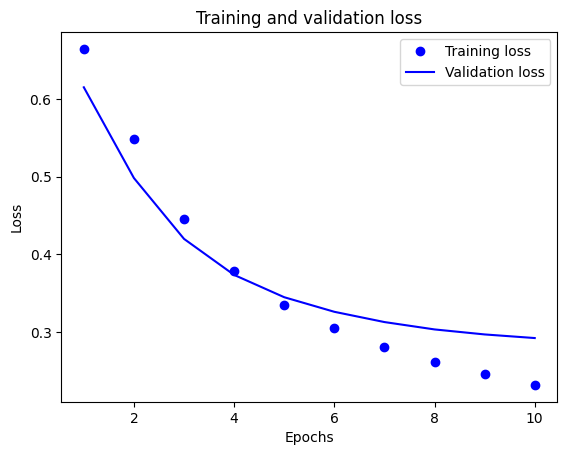

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

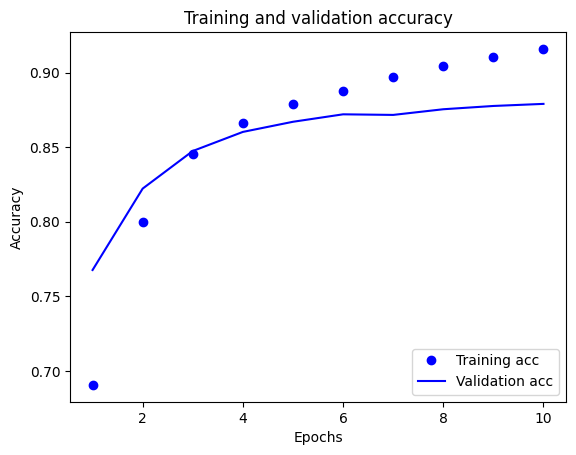

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다.

훈련 손실은 각 epoch마다 *감소*하고 훈련 정확성은 각 epoch마다 *증가*합니다. 경사 하강 최적화를 사용할 때 이와 같이 예상됩니다. 모든 반복에서 원하는 수량을 최소화해야 합니다.

하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 훈련 정확도 이전이 피크인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 모델이 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 *일반화*되지 않는 훈련 데이터의 *특정* 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 검증 정확도가 더 이상 증가하지 않는 경우에 훈련을 중단할 수 있습니다. 이를 수행하는 한 가지 방법은 `tf.keras.callbacks.EarlyStopping` 콜백을 사용하는 것입니다.

## 모델 내보내기

위의 코드에서는 모델에 텍스트를 제공하기 전에 `TextVectorization` 레이어를 데이터세트에 적용했습니다. 모델이 원시 문자열을 처리할 수 있도록 하려면(예: 배포를 단순화하기 위해) 모델 내부에 `TextVectorization` 레이어를 포함할 수 있습니다. 이를 위해 방금 훈련한 가중치를 사용하여 새 모델을 만들 수 있습니다.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 3:12 - loss: 0.1965 - accuracy: 0.9375

 15/782 [..............................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8917  

 29/782 [>.............................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8836

 43/782 [>.............................] - ETA: 2s - loss: 0.3005 - accuracy: 0.8830

 57/782 [=>............................] - ETA: 2s - loss: 0.2990 - accuracy: 0.8843

 71/782 [=>............................] - ETA: 2s - loss: 0.3033 - accuracy: 0.8781

 85/782 [==>...........................] - ETA: 2s - loss: 0.2985 - accuracy: 0.8798

 99/782 [==>...........................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8788

113/782 [===>..........................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8775

127/782 [===>..........................] - ETA: 2s - loss: 0.3014 - accuracy: 0.8757

142/782 [====>.........................] - ETA: 2s - loss: 0.3027 - accuracy: 0.8757

156/782 [====>.........................] - ETA: 2s - loss: 0.3059 - accuracy: 0.8750

170/782 [=====>........................] - ETA: 2s - loss: 0.3084 - accuracy: 0.8735

184/782 [======>.......................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8725

198/782 [======>.......................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8725

212/782 [=======>......................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8723

226/782 [=======>......................] - ETA: 2s - loss: 0.3116 - accuracy: 0.8721

240/782 [========>.....................] - ETA: 1s - loss: 0.3118 - accuracy: 0.8727

254/782 [========>.....................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8738

268/782 [=========>....................] - ETA: 1s - loss: 0.3102 - accuracy: 0.8735

282/782 [=========>....................] - ETA: 1s - loss: 0.3085 - accuracy: 0.8738

296/782 [==========>...................] - ETA: 1s - loss: 0.3074 - accuracy: 0.8738

310/782 [==========>...................] - ETA: 1s - loss: 0.3069 - accuracy: 0.8738

324/782 [===========>..................] - ETA: 1s - loss: 0.3070 - accuracy: 0.8738

338/782 [===========>..................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8732

352/782 [============>.................] - ETA: 1s - loss: 0.3072 - accuracy: 0.8732

366/782 [=============>................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8728

380/782 [=============>................] - ETA: 1s - loss: 0.3093 - accuracy: 0.8723

395/782 [==============>...............] - ETA: 1s - loss: 0.3088 - accuracy: 0.8727

409/782 [==============>...............] - ETA: 1s - loss: 0.3081 - accuracy: 0.8730

423/782 [===============>..............] - ETA: 1s - loss: 0.3075 - accuracy: 0.8737

437/782 [===============>..............] - ETA: 1s - loss: 0.3080 - accuracy: 0.8734

451/782 [================>.............] - ETA: 1s - loss: 0.3070 - accuracy: 0.8744

466/782 [================>.............] - ETA: 1s - loss: 0.3071 - accuracy: 0.8739

480/782 [=================>............] - ETA: 1s - loss: 0.3067 - accuracy: 0.8741

495/782 [=================>............] - ETA: 1s - loss: 0.3077 - accuracy: 0.8734

509/782 [==================>...........] - ETA: 0s - loss: 0.3084 - accuracy: 0.8732

523/782 [===================>..........] - ETA: 0s - loss: 0.3082 - accuracy: 0.8734

537/782 [===================>..........] - ETA: 0s - loss: 0.3083 - accuracy: 0.8735

551/782 [====================>.........] - ETA: 0s - loss: 0.3078 - accuracy: 0.8738

565/782 [====================>.........] - ETA: 0s - loss: 0.3081 - accuracy: 0.8736

579/782 [=====================>........] - ETA: 0s - loss: 0.3090 - accuracy: 0.8726

593/782 [=====================>........] - ETA: 0s - loss: 0.3100 - accuracy: 0.8718

607/782 [======================>.......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8720

621/782 [======================>.......] - ETA: 0s - loss: 0.3102 - accuracy: 0.8720

636/782 [=======================>......] - ETA: 0s - loss: 0.3104 - accuracy: 0.8719

650/782 [=======================>......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8715

665/782 [========================>.....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8719

679/782 [=========================>....] - ETA: 0s - loss: 0.3100 - accuracy: 0.8719

693/782 [=========================>....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8723

708/782 [==========================>...] - ETA: 0s - loss: 0.3097 - accuracy: 0.8722

722/782 [==========================>...] - ETA: 0s - loss: 0.3093 - accuracy: 0.8723

737/782 [===========================>..] - ETA: 0s - loss: 0.3099 - accuracy: 0.8723

751/782 [===========================>..] - ETA: 0s - loss: 0.3103 - accuracy: 0.8722

766/782 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8727

781/782 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8730

782/782 [==============================] - 3s 4ms/step - loss: 0.3107 - accuracy: 0.8730


0.8730400204658508


### 새로운 데이터로 추론하기

새로운 예에 대한 예측을 얻으려면 간단히 `model.predict()`를 호출하면 됩니다.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 137ms/step


array([[0.6096767],
       [0.4326959],
       [0.3506354]], dtype=float32)

모델 내부에 텍스트 전처리 논리를 포함하면 배포를 단순화하고 [훈련/테스트 왜곡](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) 가능성을 줄이는 프로덕션용 모델을 내보낼 수 있습니다.

TextVectorization 레이어를 적용할 위치를 선택할 때 염두에 두어야 할 성능 차이가 있습니다. 레이어를 모델 외부에서 사용하면 GPU에서 훈련할 때 비동기 CPU 처리 및 데이터 버퍼링을 수행할 수 있습니다. 따라서 GPU에서 모델을 훈련하는 경우 모델을 개발하는 동안 최상의 성능을 얻기 위해 이 옵션을 사용하고 배포 준비가 완료되면 모델 내부에 TextVectorization 레이어를 포함하도록 전환할 수 있습니다.

모델 저장에 대해 자세히 알아보려면 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/save_and_load)을 방문하세요.

## 연습: 스택 오버플로 질문에 대한 다중 클래스 분류

이 튜토리얼은 IMDB 데이터세트에서 이진 분류자를 처음부터 훈련하는 방법을 보여주었습니다. 연습으로, 이 노트북을 수정하여 [스택 오버플로](http://stackoverflow.com/)에서 프로그래밍 질문의 태그를 예측하도록 다중 클래스 분류자를 훈련할 수 있습니다.

스택 오버플로에 게시된 수천 개의 프로그래밍 질문(예: "Python에서 값을 기준으로 사전을 정렬할 수 있는 방법은?")의 본문이 포함된 [데이터세트](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)가 준비되어 있습니다. 이들 각각은 정확히 하나의 태그(Python, CSharp, JavaScript 또는 Java)로 레이블이 지정됩니다. 여러분이 할 작업은 질문을 입력으로 받아 적절한 태그(이 경우 Python)를 예측하는 것입니다.

작업할 데이터세트에는 1,700만 개 이상의 게시물이 포함된 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow)의 훨씬 더 큰 공개 스택 오버플로 데이터세트에서 추출한 수천 개의 질문이 포함되어 있습니다.

데이터세트를 다운로드해 보면 이전에 작업한 IMDB 데이터세트와 유사한 디렉터리 구조를 가지고 있음을 알 수 있습니다.

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

참고: 분류 문제의 난이도를 높이기 위해 프로그래밍 질문에서 Python, CSharp, JavaScript 또는 Java라는 단어의 출현은 *blank*라는 단어로 대체되었습니다(많은 질문에 해당 언어가 포함됨).

이 연습을 완료하려면 다음과 같이 수정하여 스택 오버플로 데이터세트와 함께 작동하도록 이 노트북을 수정해야 합니다.

1. 노트북 상단에서, 미리 준비된 [스택 오버플로 데이터세트](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)를 다운로드하는 코드로 IMDB 데이터세트를 다운로드하는 코드를 업데이트합니다. 스택 오버플로 데이터세트는 유사한 디렉터리 구조를 가지므로 많이 수정할 필요가 없습니다.

2. 이제 4개의 출력 클래스가 있으므로 `Dense(4)`를 읽도록 모델의 마지막 레이어를 수정합니다.

3. 모델을 컴파일할 때 손실을 `tf.keras.losses.SparseCategoricalCrossentropy`로 변경합니다. 이것은 각 클래스의 레이블이 정수일 때(이 경우 0, *1*, *2* 또는 *3*일 수 있음) 다중 클래스 분류 문제에 사용할 올바른 손실 함수입니다. 또한 이것은 다중 클래스 분류 문제이기 때문에 메트릭을 `metrics=['accuracy']`로 변경합니다(`tf.metrics.BinaryAccuracy`는 이진 분류자에만 사용됨).

4. 시간 경과에 따른 정확도를 표시할 때 `binary_accuracy` 및 `val_binary_accuracy`를 각각 `accuracy` 및 `val_accuracy`로 변경합니다.

5. 이러한 변경이 완료되면 다중 클래스 분류자를 훈련할 수 있습니다. 

## 더 알아보기

이 튜토리얼은 텍스트 분류를 처음부터 알아보았습니다. 일반적인 텍스트 분류 워크플로에 대해 자세히 알아보려면 Google Developers의 [텍스트 분류 가이드](https://developers.google.com/machine-learning/guides/text-classification/)를 확인하세요.
